<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/AIPI509_XAI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Interpretable ML
**Adil Keku Gazder**

**ag825@duke.edu**

**For AIPI 590 - XAI, Fall 2025**

**Duke University**



This notebook will use a telecommunications dataset to compare the performance of Linear Regression, Logistic Regression and Generalized Additive Models (GAMs) and analyze the accuracy of the same. We also test assumptions in detail.

### **Code to connect with github**

Adapted from the starter code shared by Brinnae Bent, shared here: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/templates/template.ipynb

In [234]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590_XAI_F25"  # Change to your repo name
git_path = 'https://github.com/ag826/AIPI590_XAI_F25.git'  # Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"  # Add if using requirements.txt

# Create a subfolder for the notebook
subfolder_name = 'Assignment-Interpretable-ML'
subfolder_path = os.path.join(repo_name, subfolder_name)
!mkdir -p "{subfolder_path}"

# Change working directory to the new subfolder
path_to_notebook = subfolder_path
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'AIPI590_XAI_F25'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 1), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 981.02 KiB | 6.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Ass

### **Installing required packages**

In [235]:
pip install pygam

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    mean_squared_error,
    mean_absolute_error
)

from pygam import LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [237]:
df=pd.read_csv("/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## **1. Exploratory Data Analysis**

Code to get a better understanding of the dataset that we are working with, including a descripitive overview, samples and null values present in each column.

We also do a tad bit of preprocessing, including grouping numeric and categoric (dtype objects) columns together, along with visualizing our outcome variable (Churn against categorical variables).

In [238]:
print("#####################################################")
print("--- Initial Data Info ---")
print("###########################w##########################")
print("")
df.info()
print("")
print("#####################################################")
print("--- First 5 Rows of Data ---")
print("#####################################################")
print("")
print(df.head())
print("")
print("#####################################################")
print("--- Null values of each column ---")
print("#####################################################")
print("")
print(df.isnull().sum())
print("")
print("#####################################################")
print("--- Data types of each column ---")
print("#####################################################")
print("")
print(df.dtypes)


#####################################################
--- Initial Data Info ---
###########################w##########################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  

In [239]:
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

categorical_features = [col for col in categorical_features if col not in ["customerID", "Churn", "TotalCharges"]]

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
numeric_features.append("TotalCharges")

Number of missing values in 'TotalCharges': 11


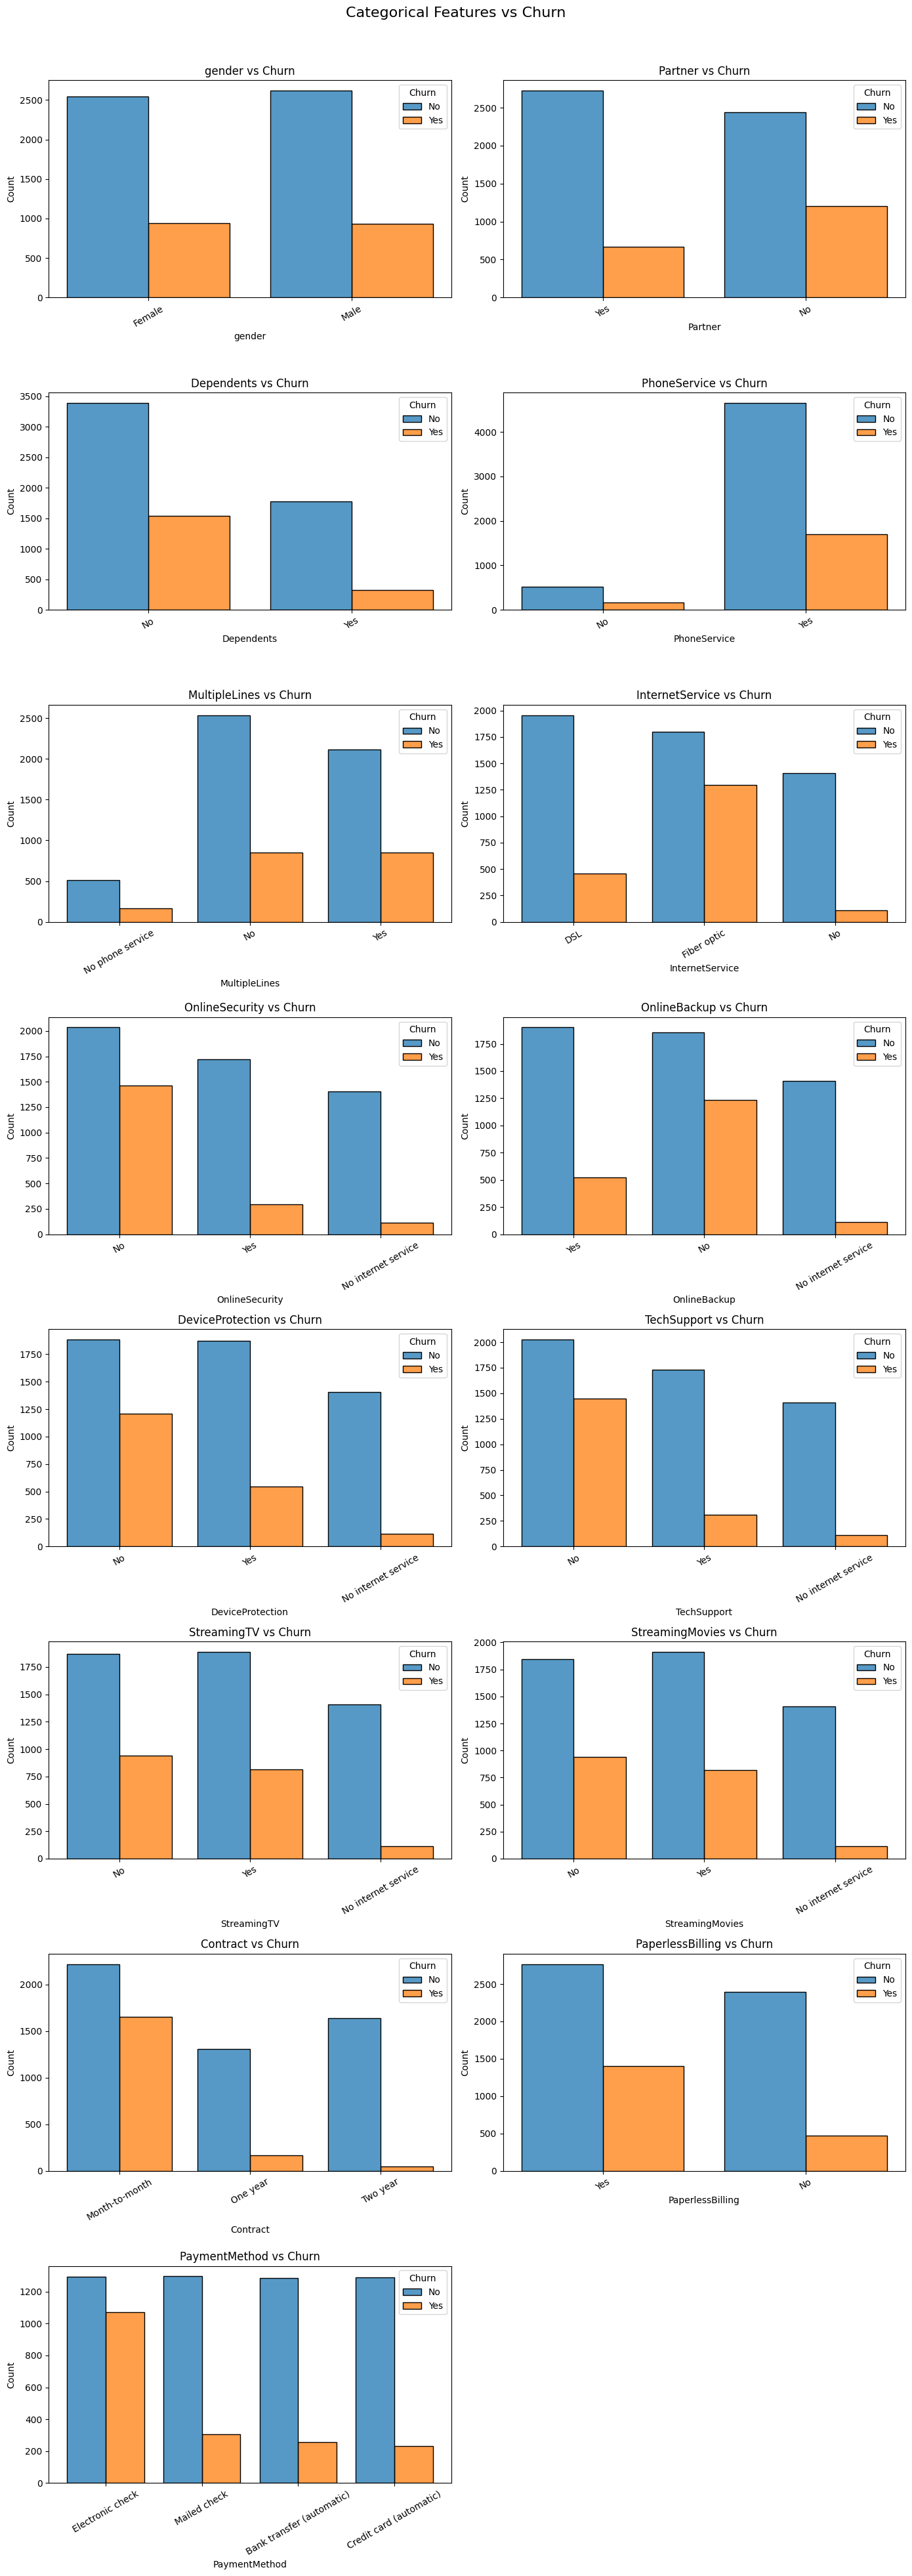

In [240]:
missing_total_charges = df["TotalCharges"].isna().sum()
print(f"Number of missing values in 'TotalCharges': {missing_total_charges}")

df = df.dropna()


fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 40))
fig.suptitle("Categorical Features vs Churn", fontsize=16)

axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    sns.histplot(data=df, x=feature, hue="Churn", multiple='dodge', shrink=0.8, ax=axes[i], stat="count")
    axes[i].set_title(f"{feature} vs Churn")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=30)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
# Parts of the formatting for this visualization loop was generated with Perplexity at 2am on 09/15

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



## **2. Linear Regression**

Treating churn as a continuous outcome variable and using it to build a linear regression model. We also test assumptions using Residuals vs Fitted and QQQ plots.

In [241]:
categorical_features.append("Churn")
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True).astype(int)

df_final = pd.concat([df[numeric_features], df_dummies], axis=1)

target = "Churn_Yes"
X_vars = df_final.drop(columns=[target])
y_var = df_final[target]

X_vars = sm.add_constant(X_vars)

vif_df = pd.DataFrame({
    "feature": X_vars.columns,
    "VIF": [variance_inflation_factor(X_vars.values, idx) for idx in range(X_vars.shape[1])]
})

linear_model = sm.OLS(y_var, X_vars).fit()

print(linear_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                            OLS Regression Results                            
Dep. Variable:              Churn_Yes   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     120.9
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        07:02:07   Log-Likelihood:                -3057.9
No. Observations:                7032   AIC:                             6164.
Df Residuals:                    7008   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

> The english interpretation of our model is as follows:
"Holding all other variables constant, for every additional unit increase in (any of the variables above), the predicted value of the churn increases by (corresponding coefficient of the variable in the table above multiplied by 100) percentage points"

> We note that the linear regression model gives an R^2 value of 0.284, ie only 28.4% of the variation in Churn (outcome variable) is explained by our model.

> On evaluating the coefficients, we see that our predictors have varying impact, some of the significant ones are discussed below:
> - People with phone service, multiple phone lines, fiber optic internet service, those who stream movies and who make their payment by electronic check are more likely to churn (coefficients relatively high)
>- People with a one year contract, dependants and with online security are less likely to churn (coefficients relatively low)

> This level of multicollinearity observed in the VIF dataframe indicates that several features are highly correlated or even redundant, which can lead to unstable coefficient estimates and unreliable statistical inference.


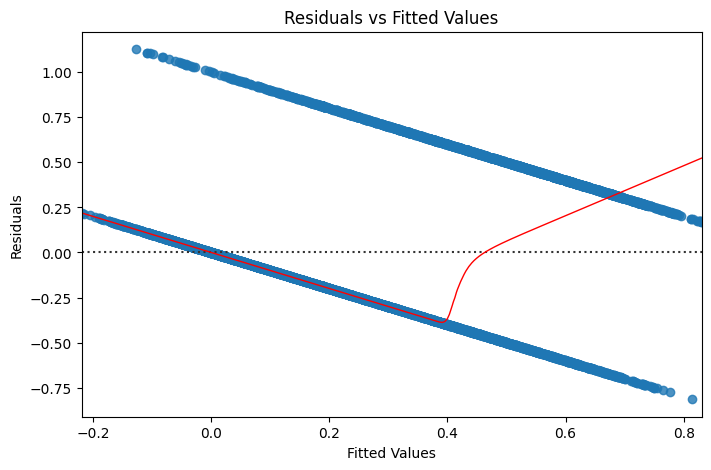

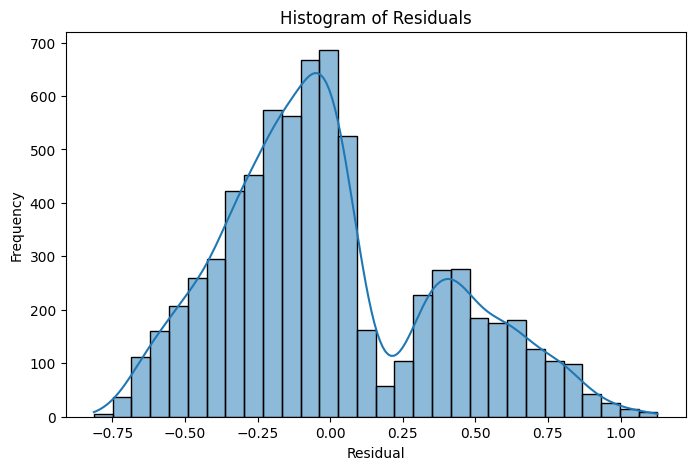

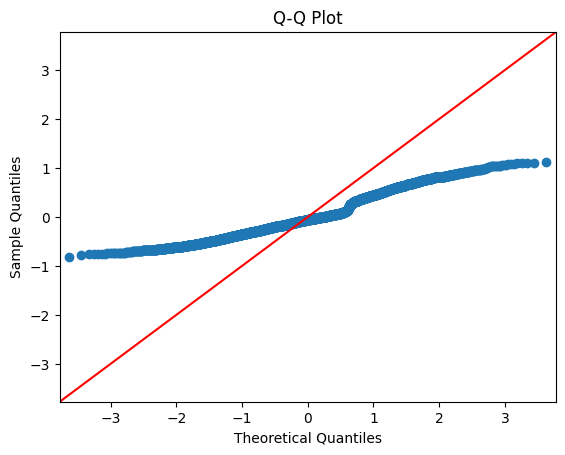

In [252]:
# Residuals vs Fitted Values plot
plt.figure(figsize=(8, 5))
sns.residplot(x=linear_model.fittedvalues, y=linear_model.resid, lowess=True,
              line_kws={"color": "red", "lw": 1})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Residuals histogram
plt.figure(figsize=(8, 5))
sns.histplot(linear_model.resid, kde=True, bins=30)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
sm.qqplot(linear_model.resid, line="45")
plt.title("Q-Q Plot")
plt.show()

> We note that with the residuals vs fitted plot, we expect a clound shape plot centered around 0.0, however we note an abnormal plot indicating a possible non linear relationship between the predictors we used and our outcome variable and a lack of heteroskedaciticity.

> With the QQQ plot, we do note a non normal distribution of errors (residuals).

Displaying confusion matrix from our model and also plotting the ROC curve.

In [257]:
recall = recall_score(y_var, y_pred_binary)
accuracy = accuracy_score(y_var, y_pred_binary)
precision = precision_score(y_var, y_pred_binary)
f1 = f1_score(y_var, y_pred_binary)
roc_auc = roc_auc_score(y_var, y_pred_binary)
mse = mean_squared_error(y_var, y_pred_binary)
mae = mean_absolute_error(y_var, y_pred_binary)

print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

Recall: 0.52
Accuracy: 0.80
Precision: 0.66
F1 Score: 0.58
ROC AUC: 0.71
MSE: 0.20
MAE: 0.20


Our model achieves an accuracy of 0.80 and a precision of 0.66, indicating that its churn predictions are generally trustworthy, while a recall of 0.52 means it manages to capture around half of the customers who actually leave. The F1 score of 0.58 reflects a balanced but moderate trade-off between catching churners and avoiding false alarms. With an ROC AUC of 0.71, the model demonstrates decent ability to distinguish between churners and non-churners, though there’s room for improvement. The error metrics (MSE and MAE of 0.20) confirm that predictions are frequently correct, but some misclassifications do occur. Overall, the model identifies most customers at risk of churn, but may still miss many true churners and create unnecessary interventions for some customers who would have stayed.

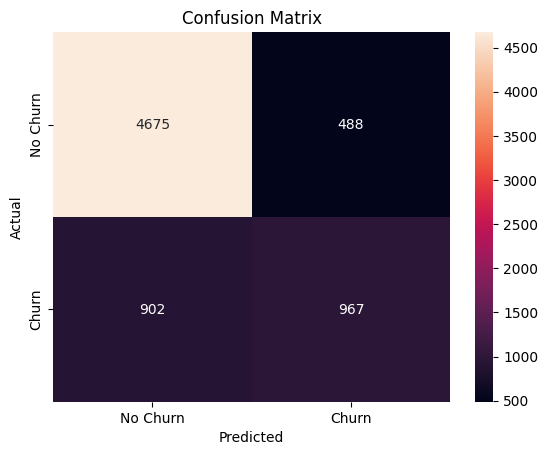

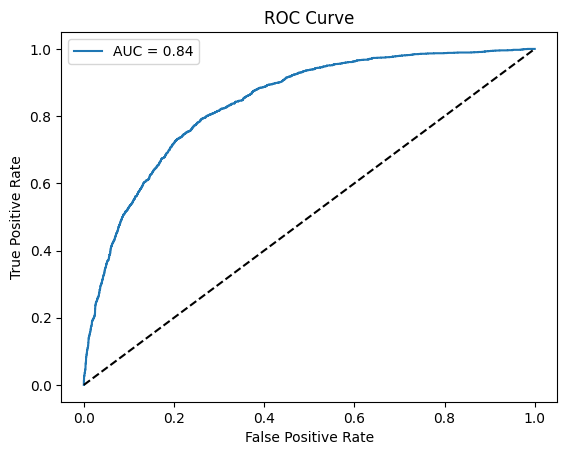

In [259]:

y_pred_continuous = linear_model.predict(X_vars)

y_pred_binary = y_pred_continuous > 0.5

conf_matrix = confusion_matrix(y_var, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, y_pred_continuous)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_var, y_pred_continuous):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



> Our model also has an ROC AUC of 0.84 meaning that the model does a very good job distinguishing between customers who will churn and those who will not.

## **3. Logistic Regression**

Treating churn as a binary outcome variable (0 or 1) and using it to build a logistic regression model.

In [245]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_vars.columns
vif_df["VIF"] = [variance_inflation_factor(X_vars.values, i) for i in range(X_vars.shape[1])]

X_reduced = X_vars.copy()
for feat, vif_val in zip(vif_df["feature"], vif_df["VIF"]):
    if vif_val == np.inf:
        X_reduced.drop(columns=[feat], inplace=True)


logistic_model = sm.Logit(y_var, X_reduced).fit()
print(logistic_model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Optimization terminated successfully.
         Current function value: 0.419697
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7010
Method:                           MLE   Df Model:                           21
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2752
Time:                        07:02:10   Log-Likelihood:                -2951.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.9994      

> The english interpretation of our logistic regression model is as follows:
"Holding all other variables constant, for every additional unit increase in (any of the variables above), the log odds value of the churn increases by (corresponding coefficient of the variable in the table)"

> The logistic regression model yields a pseudo R-squared value of 0.275, indicating that approximately 27.5% of the variation in customer churn is explained by the model.

> Examining the coefficients, we observe that the predictors influence churn risk in different ways, with several notable effects:

> - Customers who are senior citizens, have fiber optic internet, use paperless billing, or make payments by electronic check are more likely to churn (these predictors have relatively higher coefficients).
> - Conversely, customers with longer tenure, a one- or two-year contract, dependents, or those who use online security or tech support are less likely to churn (these variables are associated with lower coefficients).

In [260]:
recall = recall_score(y_var, y_pred_binary)
accuracy = accuracy_score(y_var, y_pred_binary)
precision = precision_score(y_var, y_pred_binary)
f1 = f1_score(y_var, y_pred_binary)
roc_auc = roc_auc_score(y_var, y_pred_binary)
mse = mean_squared_error(y_var, y_pred_binary)
mae = mean_absolute_error(y_var, y_pred_binary)

print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

Recall: 0.52
Accuracy: 0.80
Precision: 0.66
F1 Score: 0.58
ROC AUC: 0.71
MSE: 0.20
MAE: 0.20


> The logistic regression model achieves an accuracy of 0.80, indicating that 80% of all predictions are correct.
Additionally, the model demonstrates a recall of 0.52—capturing 52% of actual churners—and a precision of 0.66, meaning that 66% of customers predicted to churn actually did so.

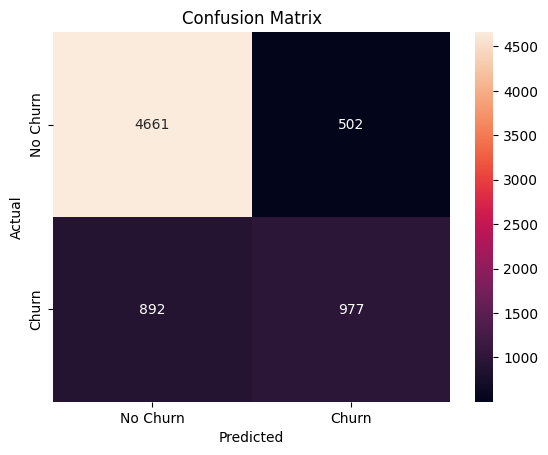

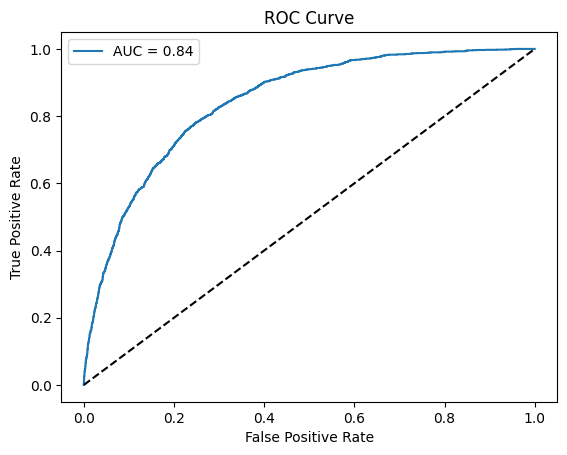

In [261]:
y_pred_binary = (logistic_model.predict(X_reduced) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_var, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, logistic_model.predict(X_reduced))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_var, logistic_model.predict(X_reduced)):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


> The confusion matrix shows that our model correctly classifies the majority of customers, accurately identifying 4,661 non-churners and 977 churners, with some misclassifications in both groups.
The ROC curve, with an AUC of 0.84, further demonstrates the model’s strong ability to distinguish between churners and non-churners, reflecting robust overall performance.

## **4. Generative Additive Models**

Modelling the non linear relationship between churn and other customer features

In [248]:
gam_model = LogisticGAM(
    s(1) + s(2) + s(3) + s(4)
    + f(5) + f(6) + f(7) + f(8)
    + f(9) + f(10) + f(11) + f(12)
    + f(13) + f(14) + f(15) + f(16)
    + f(17) + f(18) + f(19) + f(20)
    + f(21)
).fit(X_reduced, y_var)

gam_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     55.7351
Link Function:                        LogitLink Log Likelihood:                                 -2833.8201
Number of Samples:                         7032 AIC:                                             5779.1104
                                                AICc:                                            5780.0498
                                                UBRE:                                               2.8282
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.304
Feature Function                  Lam

/tmp/ipython-input-3094009575.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


> The GAM reveals that several predictors, both continuous and categorical, have a statistically significant impact on churn, as reflected by their low p-values and higher degrees of freedom. Notably, the model uncovers important non-linear effects in some features, enhancing our understanding of how certain variables influence customer behavior. Meanwhile, other predictors show little to no significant association with churn, suggesting that their effect is minimal in the context of the model.

In [263]:
y_pred_prob = gam_model.predict_proba(X_reduced)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

print(f"Recall: {recall_score(y_var, y_pred_class):.2f}")
print(f"Accuracy: {accuracy_score(y_var, y_pred_class):.2f}")
print(f"Precision: {precision_score(y_var, y_pred_class):.2f}")
print(f"F1 Score: {f1_score(y_var, y_pred_class):.2f}")
print(f"ROC AUC: {roc_auc_score(y_var, y_pred_prob):.2f}")


Recall: 0.54
Accuracy: 0.81
Precision: 0.68
F1 Score: 0.60
ROC AUC: 0.86


> The model achieves an accuracy of 81%, correctly identifying the majority of both churners and non-churners in the dataset.
A recall of 0.54 indicates that just over half of all customers who actually churned were successfully detected by the model, while a precision of 0.68 suggests that most customers flagged as likely to churn did in fact leave.
This balance reflects a model that is reasonably effective at finding those at risk while also maintaining a good level of confidence in its positive churn predictions, making it a useful tool for targeted retention strategies—though there is still room to improve recall and capture more churners.

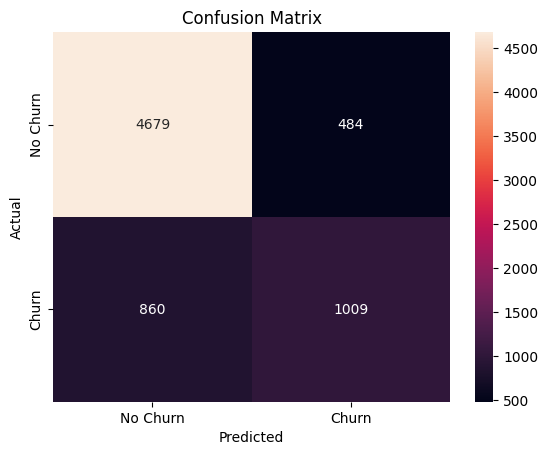

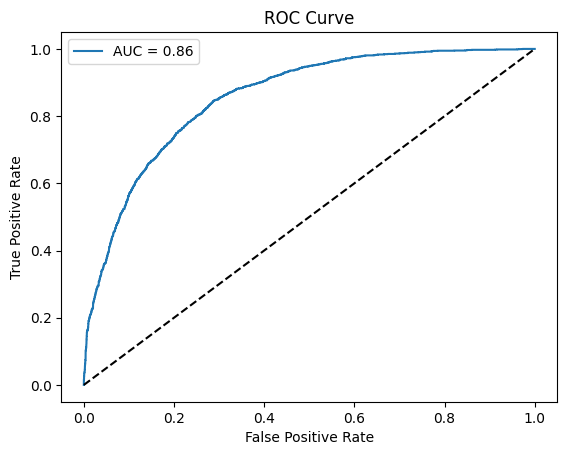

In [264]:
conf_matrix = confusion_matrix(y_var, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_var, y_pred_prob):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


> The confusion matrix indicates that the model is effective at identifying both churners and non-churners, with the majority of customers correctly classified into their respective groups. The ROC curve, with an AUC of 0.86, reflects an even stronger ability to separate churners from non-churners, demonstrating improved overall predictive performance and robustness.

## **5. Model Comparison**

Comparing all the models we had evaluated above

> Comparing the three models, linear regression offers the simplest interpretation and is useful for quickly understanding broad trends in the data, but it is less suited for binary outcomes and cannot capture complex feature effects. Logistic regression, designed for classification, balances interpretability and predictive performance, clearly highlighting key risk factors for churn while handling binary outcomes effectively, though it is still limited to linear feature relationships. The Generalized Additive Model surpasses both in predictive power by accommodating non-linear and more intricate patterns in the data, offering richer insights, but with added complexity that can make interpretation less straightforward for business stakeholders.

> In terms of predictive performance, the **Generalized Additive Model (GAM) outperforms both the linear and logistic regression models**, achieving higher accuracy and a stronger ability to distinguish between churners and non-churners. While the linear and logistic models provide solid baseline results, the GAM’s capacity to capture complex, non-linear relationships translates directly into more reliable and robust churn predictions.

> When it comes to interpretability, l**inear and logistic regression models are the most straightforward**, offering clear and direct insight into how each predictor influences customer churn, whereas the Generalized Additive Model, while still interpretable through smooth plots of feature effects, introduces more complexity as it captures non-linear relationships, making its results slightly less transparent for quick, high-level understanding.